![image.png](wide-baseline-stereo-demo_files/att_00000.png)

## In the first part of the course we implement from scratch complete wide baseline stereo pipeline.


Let's first do in in OpenCV to get the high-level understanding of the steps. We have two image as an input and would like to get corresponces and perspective transform between them.

Success!


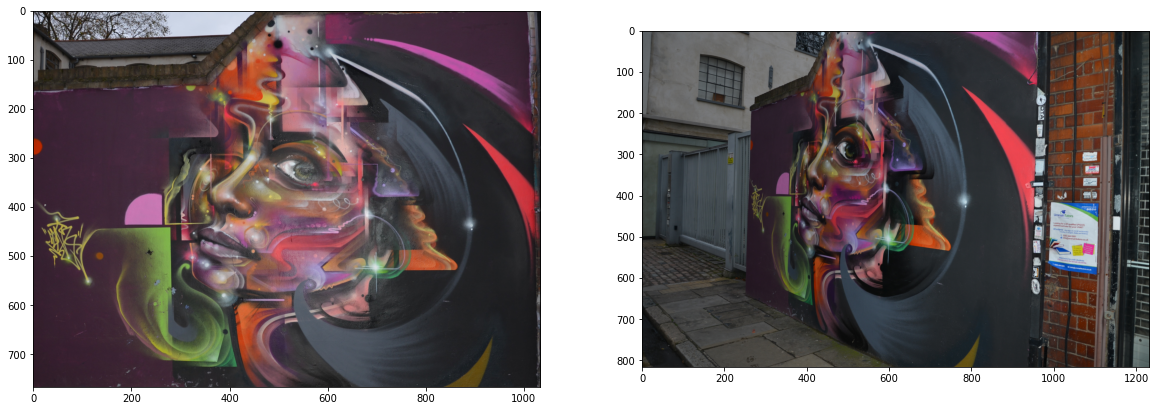

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
#Images are taken from HSequences dataset https://github.com/hpatches/hpatches-dataset
img1 = cv2.cvtColor(cv2.imread('v_woman1.ppm'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('v_woman6.ppm'), cv2.COLOR_BGR2RGB)
H_gt = np.loadtxt('v_woman_H_1_6')

def show_two_images(img1, img2):
    fig=plt.figure(figsize=(20,10))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img1)
    fig.add_subplot(1, 2, 2)
    plt.imshow(img2)
    return

show_two_images(img1, img2)
print("Success!")

## Labs 1 and 2: local feature detection and description

![image.png](wide-baseline-stereo-demo_files/att_00001.png)

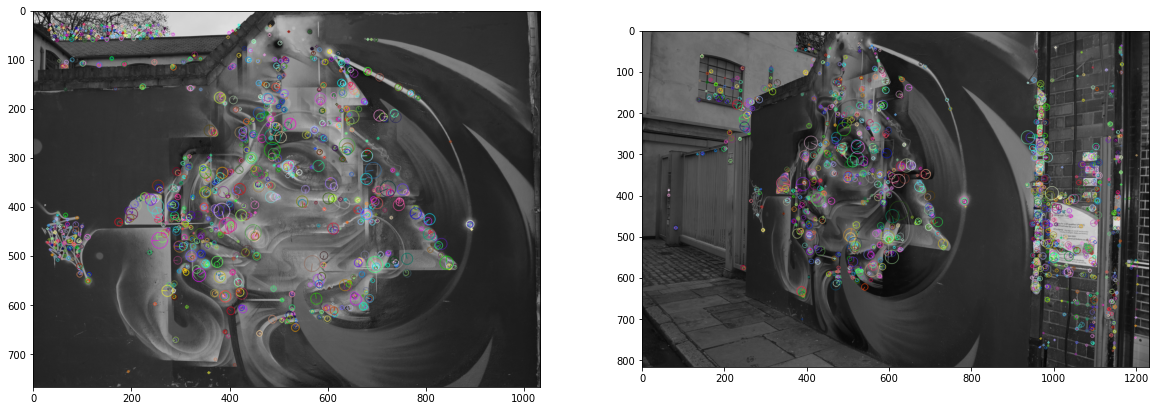

In [3]:
det = cv2.AKAZE_create()    

kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)


vis_img1, vis_img2 = None,None
vis_img1 = cv2.drawKeypoints(cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY),kps1,vis_img1, 
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
vis_img2 = cv2.drawKeypoints(cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY),kps2,vis_img2, 
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

show_two_images(vis_img1, vis_img2)

## Lab 3: getting tentative correspondence
![image.png](wide-baseline-stereo-demo_files/att_00002.png)

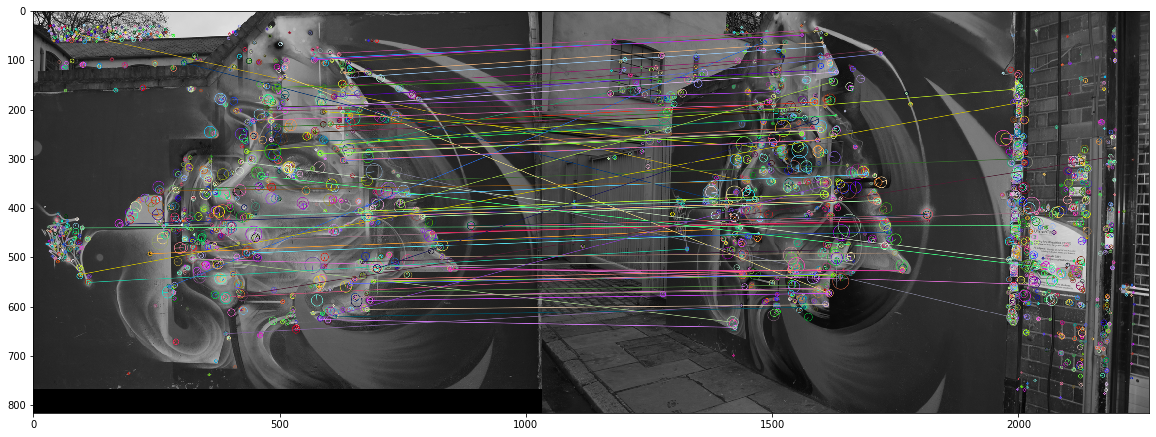

In [3]:
def match_descriptors(descriptors1, descriptors2):
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    knn_matches = matcher.knnMatch(descriptors1, descriptors2, 2)

    ratio_thresh = 0.8
    tentative_matches = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            tentative_matches.append(m)
    return tentative_matches

def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)


tentative_matches = match_descriptors(descs1, descs2)
img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)

cv2.drawMatches(decolorize(img1), kps1, decolorize(img2), kps2, tentative_matches, img_matches, 
                flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20,10))
plt.imshow(img_matches)


## Lab 3: RANSAC

![image.png](wide-baseline-stereo-demo_files/att_00003.png)

In [4]:
def draw_matches(kps1, kps2, tentative_matches, H,  H_gt, inlier_mask, img1, img2):
    matchesMask = inlier_mask.ravel().tolist()
    h,w,ch = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, H)
    #Ground truth transformation
    dst_GT = cv2.perspectiveTransform(pts, H_gt)
    img2_tr = cv2.polylines(decolorize(img2),[np.int32(dst)],True,(0,0,255),3, cv2.LINE_AA)
    img2_tr = cv2.polylines(deepcopy(img2_tr),[np.int32(dst_GT)],True,(0,255,0),3, cv2.LINE_AA)
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 20)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2_tr,kps2,tentative_matches,None,**draw_params)
    plt.figure(figsize=(20,10))
    plt.imshow(img_out)
    return

In [5]:
import torch
src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentative_matches ]).reshape(-1,2)
dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentative_matches ]).reshape(-1,2)

tentative_matches_torch = torch.cat([torch.from_numpy(src_pts), 
                                     torch.from_numpy(dst_pts)], dim=1)
print (tentative_matches_torch.shape)
torch.save(tentative_matches_torch, 'v_woman1-6_tentatives.pth')
load_matches = torch.load('v_woman1-6_tentatives.pth')
print (load_matches)

torch.Size([87, 4])
tensor([[  89.8345,   46.3240,  417.2911,  345.8504],
        [ 624.0382,  103.5040,  563.3307,   40.8374],
        [ 632.7324,  124.4587,  568.4907,   62.7313],
        [ 679.1925,  265.8974,  595.6791,  211.6564],
        [ 646.5711,  286.7677,  570.3447,  239.0119],
        [ 892.4807,  445.8519,  784.3040,  425.9046],
        [ 580.4567,  626.0550,  390.8137,  641.6972],
        [ 568.5308,   87.3604,  526.5983,   39.5042],
        [ 566.9930,   96.3872,  527.4811,   48.2092],
        [ 574.7036,   98.3571,  527.4811,   48.2092],
        [ 639.3100,  134.2419,  572.7658,   71.7651],
        [ 783.8077,  178.8235,  686.4891,   86.2340],
        [ 592.0940,  204.2955,  432.9121,  275.4167],
        [ 571.3741,  245.5523,  521.1473,  203.7614],
        [ 612.4790,  279.2921,  238.5687,  143.9885],
        [ 424.1572,  305.8887,  948.5583,  504.2963],
        [ 296.2350,  361.3721,  957.8708,  300.0385],
        [ 669.3672,  410.6969,  581.1181,  376.1915],
        

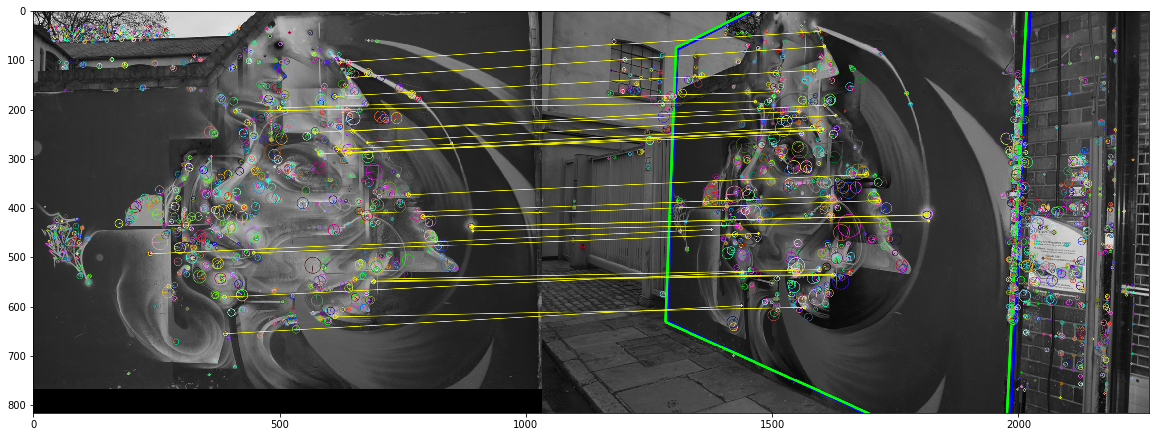

In [6]:
#Geometric verification (RANSAC)
from copy import deepcopy
def verify(tentative_matches, kps1, kps2):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentative_matches ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentative_matches ]).reshape(-1,2)
    H, inlier_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,1.0)
    return H, inlier_mask
    

H, inliers =  verify(tentative_matches, kps1, kps2)

draw_matches(kps1, kps2, tentative_matches, H, H_gt, inliers, img1, img2)